# ANALYSIS OF FX VANILLA OPTIONS

In this notebook I show how you can analyse Vanilla European Call and Put FX options

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.finutils import *
from financepy.products.fx import *
from financepy.market.curves import *
from financepy.market.volatility import *

####################################################################
# FINANCEPY BETA Version 0.190 - This build:  27 Dec 2020 at 20:45 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



# Creating the Option

We need to set up the option details - what you would find in the Term Sheet.

In [3]:
valueDate = FinDate(10, 4, 2020)

In [4]:
forName = "EUR"
domName = "USD"
forCCRate = 0.03460  # EUR
domCCRate = 0.02940  # USD

In [5]:
domDiscountCurve = FinDiscountCurveFlat(valueDate, domCCRate)
forDiscountCurve = FinDiscountCurveFlat(valueDate, forCCRate)

In [6]:
currencyPair = forName + domName
spotFXRate = 1.3465        

In [7]:
expiryDate = valueDate.addTenor("1Y")

In [8]:
strikePrice = 1.362024

We now create the option object

In [105]:
callOption = FinFXVanillaOption(expiryDate, strikePrice, currencyPair, FinOptionTypes.EUROPEAN_CALL, 1.0, "EUR")

In [106]:
print(callOption)

OBJECT TYPE: FinFXVanillaOption
EXPIRY DATE: 10-APR-2021
CURRENCY PAIR: EURUSD
PREMIUM CCY: EUR
STRIKE FX RATE: 1.362024
OPTION TYPE: FinOptionTypes.EUROPEAN_CALL
SPOT DAYS: 0
NOTIONAL: 1.0


## Valuation Dependency on Spot FX Rate

To do a valuation we need to specify the date and set the market inputs

In [107]:
spotFXRate = np.linspace(0.1,3.0,50)

For simplicity the discount curve is assumed to be flat here (we can pass in any discount curve) and is created as follows.

The valuation model we use is Black-Scholes which is passed in as a Black-Scholes model object. It is created as follows.

In [108]:
volatility = 0.20
model = FinModelBlackScholes(volatility)

The valuation is as follows and the output is in a dictionary

In [109]:
callValue = callOption.value(valueDate, spotFXRate, domDiscountCurve, forDiscountCurve, model)

In [110]:
labels = ['v', 'cash_dom', 'cash_for', 'pips_dom', 'pips_for', 'pct_dom', 'pct_for']

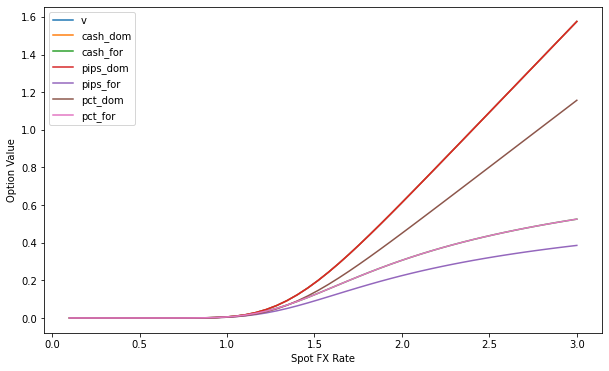

In [111]:
plt.figure(figsize=(10,6))

for labelName in labels:
    plt.plot(spotFXRate, callValue[labelName], label=labelName)

plt.xlabel("Spot FX Rate")
plt.ylabel("Option Value")
plt.legend();

## Delta Dependency on Spot FX Rate

In [112]:
deltaValue = callOption.delta(valueDate, spotFXRate, domDiscountCurve, forDiscountCurve, model)

In [113]:
labels = ['pips_spot_delta', 'pips_fwd_delta', 'pct_spot_delta_prem_adj', 'pct_fwd_delta_prem_adj']

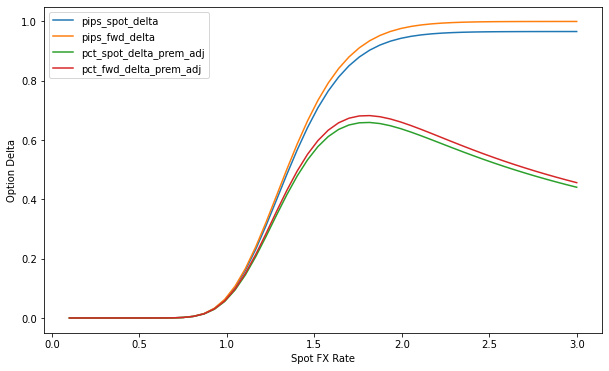

In [114]:
plt.figure(figsize=(10,6))

for labelName in labels:
    plt.plot(spotFXRate, deltaValue[labelName], label=labelName)

plt.xlabel("Spot FX Rate")
plt.ylabel("Option Delta")
plt.legend();

Note that the premium adjusted delta is not monotonic in the spot FX rate.

## Volatility Dependency

We can see how the value depends on volatility

In [115]:
spotFXRate = 1.3465

In [116]:
volatilities = np.linspace(0.01,10,100)
models = FinModelBlackScholes(volatilities)
values = callOption.value(valueDate, spotFXRate, domDiscountCurve, forDiscountCurve, models)

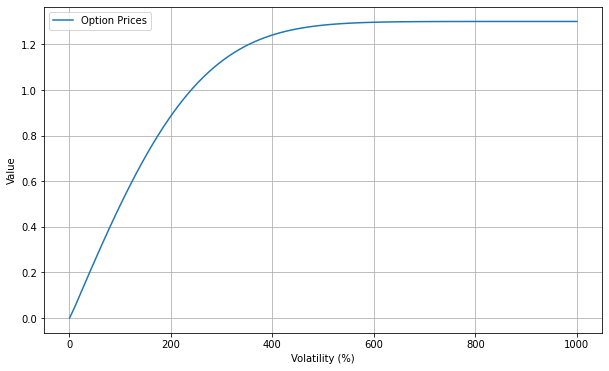

In [117]:
plt.figure(figsize=(10,6))
plt.plot(volatilities*100,values['v'], label="Option Prices")
plt.xlabel("Volatility (%)")
plt.ylabel("Value")
plt.legend()
plt.grid()

## Strike Price Dependency

We examine the strike dependency

In [118]:
strikePrices = np.linspace(0.5,3,50)

But as these are part of the option description - so we need to first vectorise those.

In [119]:
callOptions = FinFXVanillaOption(expiryDate, strikePrices, currencyPair, FinOptionTypes.EUROPEAN_CALL, 1.0, "EUR")

Look, we have an array of callOptions with different strikes

Then we can get back a vector of values

In [120]:
callValues = callOptions.value(valueDate, spotFXRate, domDiscountCurve, forDiscountCurve, model)

In [121]:
labels = ['v', 'cash_dom', 'cash_for', 'pips_dom', 'pips_for', 'pct_dom', 'pct_for']

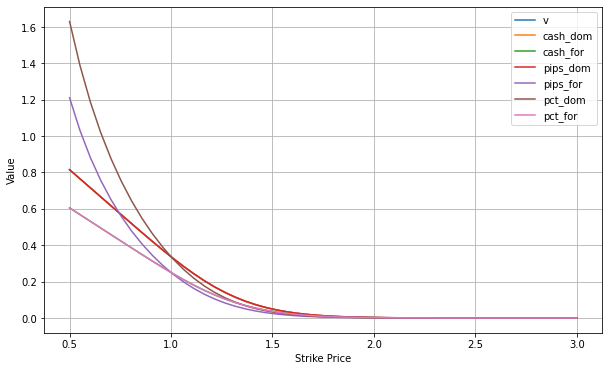

In [122]:
plt.figure(figsize=(10,6))

for labelName in labels:
    plt.plot(strikePrices, callValues[labelName], label=labelName)

plt.xlabel("Strike Price")
plt.ylabel("Value")
plt.legend()
plt.grid()

In [123]:
strikePrices = np.linspace(0.01,3,50)

In [124]:
callOptions = FinFXVanillaOption(expiryDate, strikePrices, currencyPair, FinOptionTypes.EUROPEAN_CALL, 1.0, "EUR")

In [125]:
deltaValues = callOptions.delta(valueDate, spotFXRate, domDiscountCurve, forDiscountCurve, model)

In [126]:
labels = ['pips_spot_delta', 'pips_fwd_delta', 'pct_spot_delta_prem_adj', 'pct_fwd_delta_prem_adj']

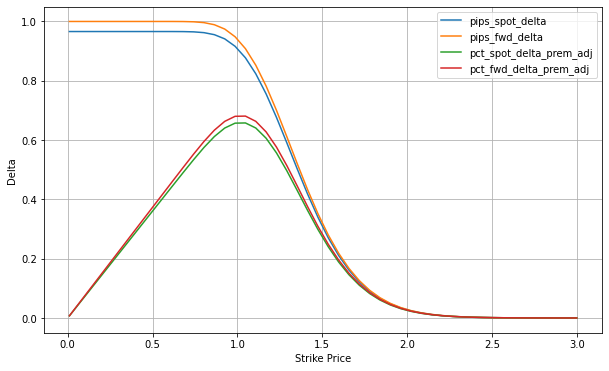

In [127]:
plt.figure(figsize=(10,6))

for labelName in labels:
    plt.plot(strikePrices, deltaValues[labelName], label=labelName)

plt.xlabel("Strike Price")
plt.ylabel("Delta")
plt.legend()
plt.grid()

We see that the delta is not a monotonic function of the strike price.

Copyright (c) 2020, Dominic O'Kane 